In [42]:
relu_path = '../output/ablation-mnist-models/relu.pkl'
relog_path = '../output/ablation-mnist-models/relog.pkl'
elliptical_path = '../output/ablation-mnist-models/relog-elliptical-maxout_4-max_fit_l1_1.pkl'
all_modifications_path = '../output/ablation-mnist-models/relog-elliptical-maxout_4-mse-max_fit_l1_1-overlay.pkl'

In [43]:
import sys
sys.path.append('..')

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision
import numpy as np
from torch.nn.functional import softmax

In [45]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

In [46]:
model_a = load_model(relu_path)
model_b = load_model(all_modifications_path)

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.CNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
dataset = torchvision.datasets.MNIST(
            root='../mnist',
            train=True,
            transform=torchvision.transforms.ToTensor(), 
            download=False,
        )
loader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False)

In [6]:
x, y = next(iter(loader))

In [7]:
# levels of noise
k = torch.linspace(0, 1, 101).reshape(-1, 1, 1, 1)

class Plotter(object):

    def __init__(self, idx=None):
        idx = idx or np.random.randint(x.shape[0])
        print("Plotting image at index %d" % idx)
        sample1 = x[[idx]]
        sample2 = torch.rand(*sample1.shape)
        self.xs = sample1 * (1-k) + sample2 * k

    def plot_transition(self):
        xs_vals = self.xs.numpy()
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        ax[0].imshow(xs_vals[0,0])
        ax[0].set_title('Noise level: 0%')
        ax[1].imshow(xs_vals[25,0])
        ax[1].set_title('Noise level: 25%')
        ax[2].imshow(xs_vals[50,0])
        ax[2].set_title('Noise level: 50%')
        ax[3].imshow(xs_vals[70,0])
        ax[3].set_title('Noise level: 75%')
        ax[4].imshow(xs_vals[100,0])
        ax[4].set_title('Noise level: 100%')

    def plot_predictions(self, model, name):
        # careful: softmax doesn't combine well with sigmoid output because the 
        # maximum possible probability is only ~0.22
        # use logit to undo the sigmoid
        model.eval()
        preds, _ = model(self.xs)
        preds = softmax(preds, dim=1)
        c0, c1 = preds[0].argsort(descending=True)[:2]
        pred_on_noise = preds[-1].clone()
        pred_on_noise[c0] = pred_on_noise[c1] = -np.inf # ignore the classes we have chosen already
        c2, c3 = pred_on_noise.argsort(descending=True)[:2]
        k_vals = k.flatten().numpy()
        for c in [c0, c1, c2, c3]:
            c = c.item()
            plt.plot(k_vals, preds[:,c].detach().numpy(), label='prediction: %d' %(c))
        plt.title('Model: ' + name)
        plt.legend()

In [48]:
p = Plotter(84)

Plotting image at index 84


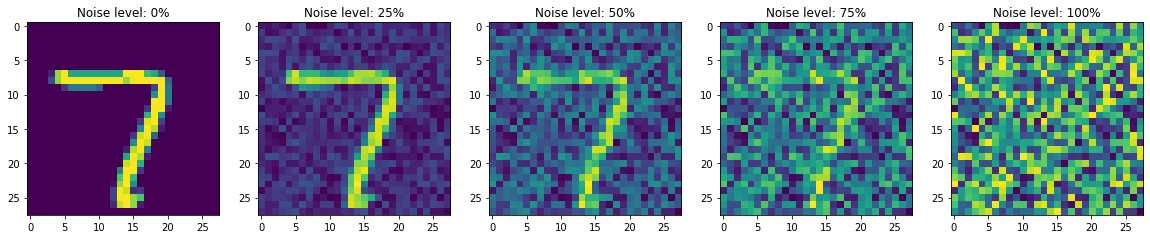

In [49]:
p.plot_transition()

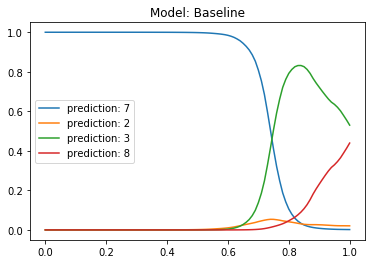

In [50]:
p.plot_predictions(model_a, 'Baseline')

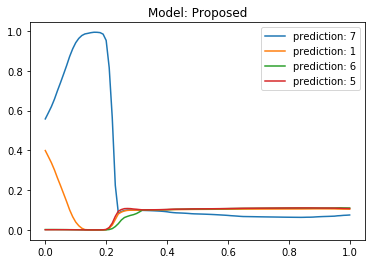

In [11]:
p.plot_predictions(model_b, 'Proposed')

In [12]:
p = Plotter(41)

Plotting image at index 41


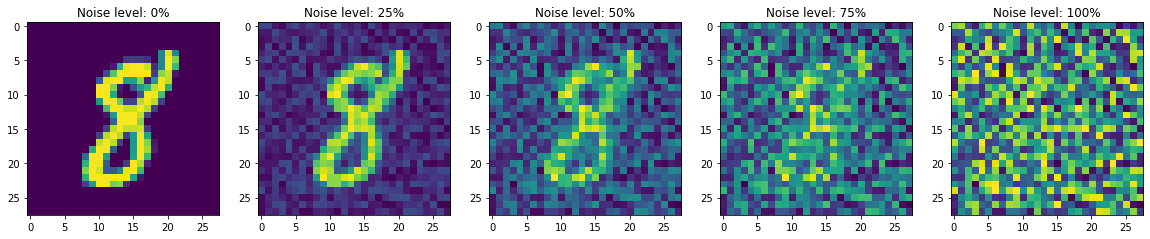

In [13]:
p.plot_transition()

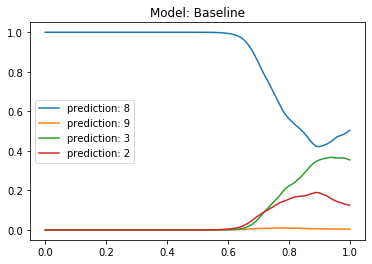

In [14]:
p.plot_predictions(model_a, 'Baseline')

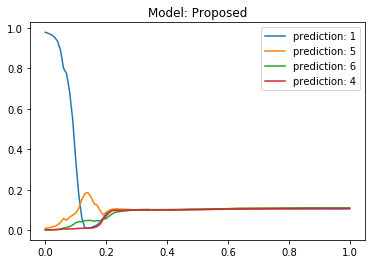

In [15]:
p.plot_predictions(model_b, 'Proposed')

In [16]:
p = Plotter(8)

Plotting image at index 8


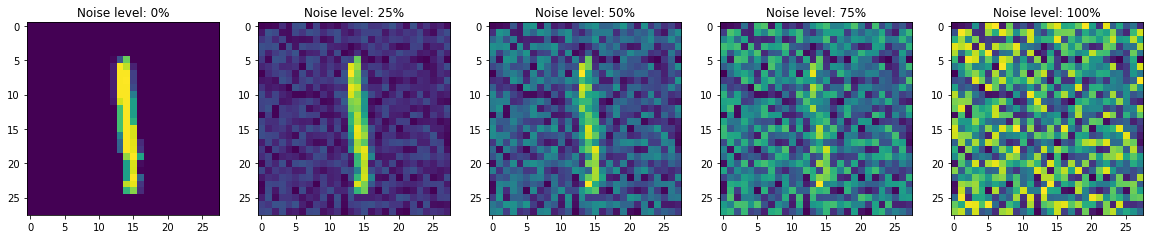

In [17]:
p.plot_transition()

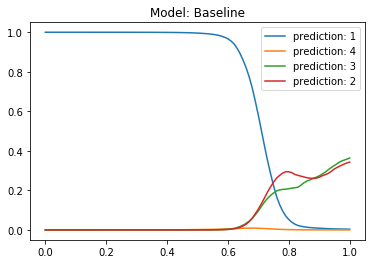

In [18]:
p.plot_predictions(model_a, 'Baseline')

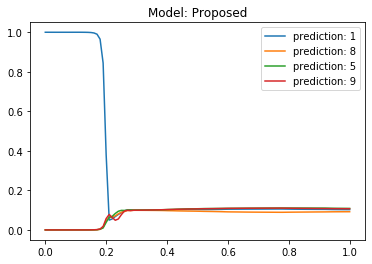

In [19]:
p.plot_predictions(model_b, 'Proposed')

Plotting image at index 2978


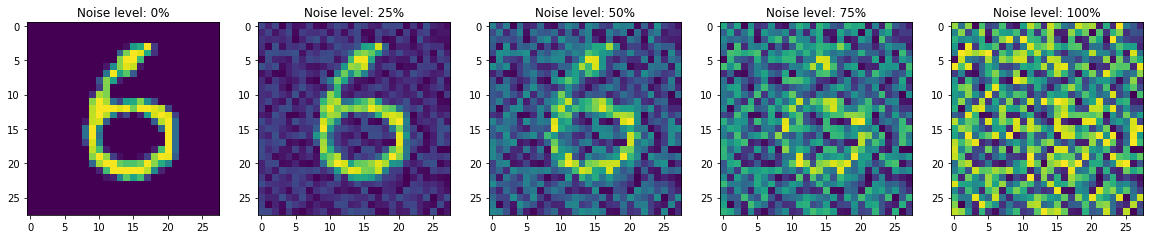

In [20]:
p = Plotter(2978)
p.plot_transition()

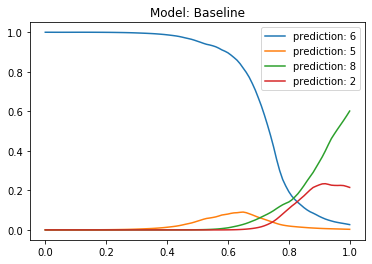

In [21]:
p.plot_predictions(model_a, 'Baseline')

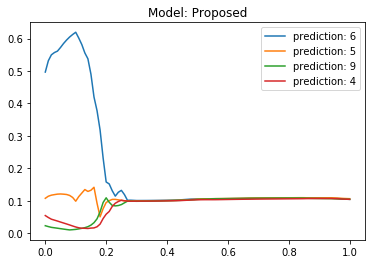

In [22]:
p.plot_predictions(model_b, 'Proposed')

# Classifying rubbish class examples

In [23]:
uniform_noise = torch.rand(*x.shape)

In [24]:
def measure_accuracy_on_noise(model):
    preds, _ = model(uniform_noise)
    max_probs, _ = softmax(preds, dim=1).max(dim=1)
    return (max_probs < 0.5).float().mean()

In [51]:
measure_accuracy_on_noise(model_a)

tensor(0.2640)

In [26]:
measure_accuracy_on_noise(model_b)

tensor(1.)

## Subtractive ablation

In [29]:
# all_modifications_path = '../output/ablation-mnist-models/relog-elliptical-maxout_4-mse-max_fit_l1_1-overlay.pkl'
minus_l1 = load_model('../output/subtractive-ablation-mnist-models/relog-elliptical-maxout_4-mse-overlay.pkl')
minus_maxout = load_model('../output/subtractive-ablation-mnist-models/relog-elliptical-mse-max_fit_l1_1-overlay.pkl')
minus_elliptical = load_model('../output/subtractive-ablation-mnist-models/relog-maxout_4-mse-max_fit_l1_1-overlay.pkl')
minus_relog = load_model('../output/subtractive-ablation-mnist-models/relu-elliptical-maxout_4-mse-max_fit_l1_1-overlay.pkl')

In [30]:
measure_accuracy_on_noise(minus_l1)

tensor(1.)

In [31]:
measure_accuracy_on_noise(minus_maxout)

tensor(1.)

In [32]:
measure_accuracy_on_noise(minus_elliptical)

tensor(1.)

In [33]:
measure_accuracy_on_noise(minus_relog)

tensor(1.)

Plotting image at index 2978


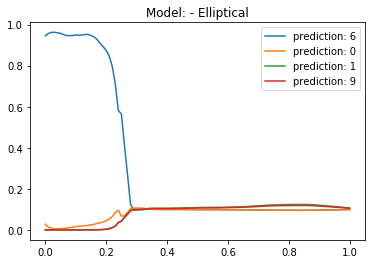

In [37]:
Plotter(2978).plot_predictions(minus_elliptical, '- Elliptical')

Plotting image at index 2978


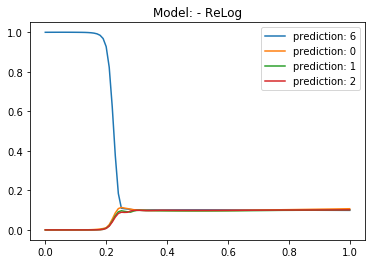

In [38]:
Plotter(2978).plot_predictions(minus_relog, '- ReLog')

In [39]:
minus_relog_elliptical = load_model('../output/subtractive-ablation-mnist-models/relu-maxout_4-mse-max_fit_l1_1-overlay.pkl')
minus_relog_maxout = load_model('../output/subtractive-ablation-mnist-models/relu-elliptical-mse-max_fit_l1_1-overlay.pkl')

In [40]:
measure_accuracy_on_noise(minus_relog_elliptical)

tensor(1.)

In [41]:
measure_accuracy_on_noise(minus_relog_maxout)

tensor(1.)

In [52]:
just_mse = load_model('../output/subtractive-ablation-mnist-models/relu-mse.pkl')
just_mse_overlay = load_model('../output/subtractive-ablation-mnist-models/relu-mse-overlay.pkl')

In [54]:
measure_accuracy_on_noise(just_mse_overlay)

tensor(1.)

In [53]:
measure_accuracy_on_noise(just_mse)

tensor(0.0206)

Notice that you can't train on negative examples (overlay) without enabling MSE training.

Plotting image at index 2978


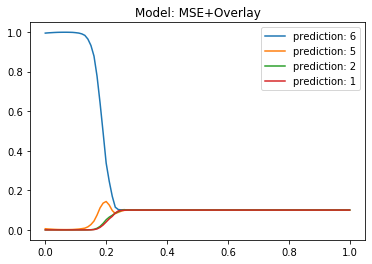

In [56]:
Plotter(2978).plot_predictions(just_mse_overlay, 'MSE+Overlay')

# Check another model: ReLog (no MSE training)

In [312]:
model_c = torch.load(relog_path, map_location=torch.device('cpu'))

Plotting image at index 8190


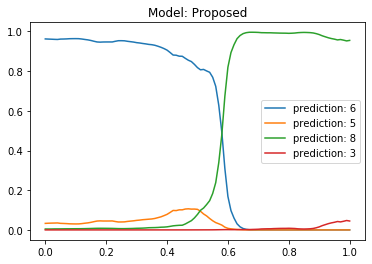

In [313]:
Plotter().plot_predictions(model_c, 'Proposed')

Plotting image at index 3899


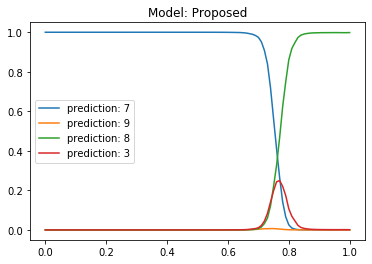

In [314]:
Plotter().plot_predictions(model_c, 'Proposed')

Plotting image at index 421


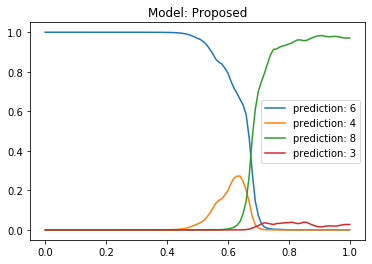

In [315]:
Plotter().plot_predictions(model_c, 'Proposed')

# Check another model: Elliptical (no MSE training)

In [316]:
model_c = torch.load(elliptical_path, map_location=torch.device('cpu'))

Plotting image at index 6


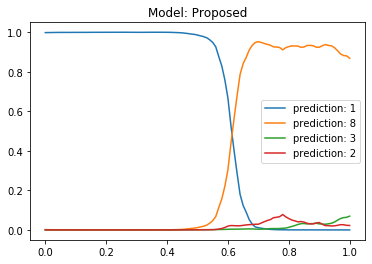

In [317]:
Plotter(6).plot_predictions(model_c, 'Proposed')

Plotting image at index 29


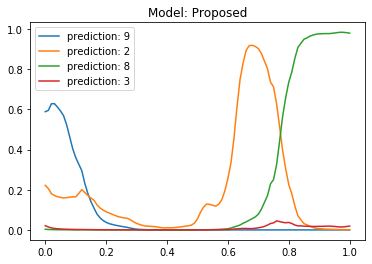

In [318]:
Plotter(29).plot_predictions(model_c, 'Proposed')

Plotting image at index 21


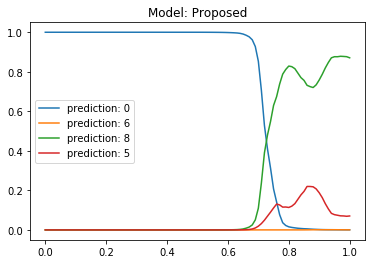

In [319]:
Plotter(21).plot_predictions(model_c, 'Proposed')